In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

# Import data and cleaning

In [ ]:
#raw data
london_flows = pd.read_csv("/content/drive/MyDrive/US_Wendi_Li/london_flows.csv")
london_flows.head(2)
london_flows.info()

# drop inflow (18)
london_flows = london_flows[london_flows["station_origin"] != london_flows["station_destination"]]
london_flows.info()

# drop population or jobs == 0
rows_to_drop = london_flows[(london_flows['population'] == 0) | (london_flows['jobs'] == 0)]
print(rows_to_drop.info()) #【43个】
london_flows = london_flows.drop(rows_to_drop.index)
london_flows.info()

# replace 0 as 0.001
london_flows['flows_c']=london_flows['flows'].replace(0, 0.001)

import statsmodels.api as sm
import statsmodels.formula.api as smf
# log
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    london_flows[f"log_{x}"] = np.log(london_flows[x])
    log_x_vars.append(f"log_{x}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61456 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61456 non-null  object 
 1   station_destination  61456 non-null  object 
 2   flows                61456 non-null  int64  
 3   population           61456 non-null  int64  
 4   jobs             

In [ ]:
london_flows.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012


# 1. Calibrate parameter


In [ ]:
flow_calibrate = london_flows.copy()
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012


In [ ]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2

    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""

    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)

    return RMSE

In [ ]:
#total flow: 1542283
pivot = pd.pivot_table(flow_calibrate, values ="flows_c", index="station_origin", columns ="station_destination",
                            aggfunc=np.sum, margins=True)
pivot

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.000,599.004
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN,1224.024
Acton Town,NaN,NaN,NaN,3.000,17.000,NaN,35.000,0.001,NaN,11.00,...,77.000,3.000,6.000,9.000,NaN,0.001,NaN,0.001,NaN,3745.052
Aldgate,NaN,NaN,0.001,NaN,0.001,NaN,NaN,0.001,NaN,17.00,...,0.001,NaN,4.000,8.000,NaN,0.001,NaN,0.001,NaN,2886.114
Aldgate East,NaN,NaN,2.000,0.001,NaN,NaN,0.001,0.001,NaN,20.00,...,24.000,0.001,0.001,12.000,NaN,1.000,NaN,1.000,NaN,3172.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.000,5.000,47.000,NaN,NaN,NaN,NaN,22.00,...,2.000,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,4868.025
Woodgrange Park,NaN,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.013
Woodside Park,NaN,NaN,1.000,26.000,11.000,NaN,0.001,NaN,NaN,59.00,...,0.001,NaN,0.001,NaN,NaN,NaN,NaN,NaN,NaN,3093.029


In [ ]:
# Your pivot_table definition
pivot = pd.pivot_table(flow_calibrate, values="flows_c", index="station_origin", columns="station_destination",
                       aggfunc=np.sum, margins=True)

# Sort the pivot table horizontally based on the 'All' row in ascending order
pivot_sort = pivot.T.sort_values(by='All', ascending=False).T

first_column = pivot_sort.pop(pivot_sort.columns[0])
pivot_sort[first_column.name] = first_column

# Saving to excel
pivot_sort.to_excel("pivot_original.xlsx", index=True)

pivot_sort

<ipython-input-79-09c7c03418f5>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_sort[first_column.name] = first_column


station_destination,Bank and Monument,Liverpool Street,Canary Wharf,Stratford,Oxford Circus,King's Cross St. Pancras,Victoria,London Bridge,Green Park,Farringdon,...,West Harrow,Cheshunt,Theydon Bois,Hatch End,West Finchley,Beckton Park,Roding Valley,Grange Hill,Emerson Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.001,NaN,1.000,285.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599.004
Acton Central,NaN,NaN,NaN,11.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001,NaN,NaN,NaN,NaN,NaN,1224.024
Acton Town,66.000,55.000,57.000,10.000,38.000,64.000,53.000,39.000,79.000,19.000,...,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3745.052
Aldgate,5.000,67.000,1.000,6.000,15.000,351.000,5.000,2.000,3.000,677.000,...,2.000,NaN,NaN,NaN,0.001,NaN,NaN,NaN,NaN,2886.114
Aldgate East,95.000,47.000,3.000,82.000,50.000,111.000,31.000,25.000,46.000,140.000,...,NaN,NaN,0.001,NaN,0.001,NaN,0.001,0.001,NaN,3172.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,317.000,424.000,192.000,891.000,119.000,49.000,68.000,72.000,25.000,47.000,...,NaN,NaN,8.000,NaN,NaN,NaN,5.000,5.000,NaN,4868.025
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.013
Woodside Park,240.000,27.000,42.000,18.000,69.000,92.000,90.000,90.000,48.000,32.000,...,NaN,NaN,NaN,NaN,14.000,NaN,NaN,NaN,NaN,3093.029


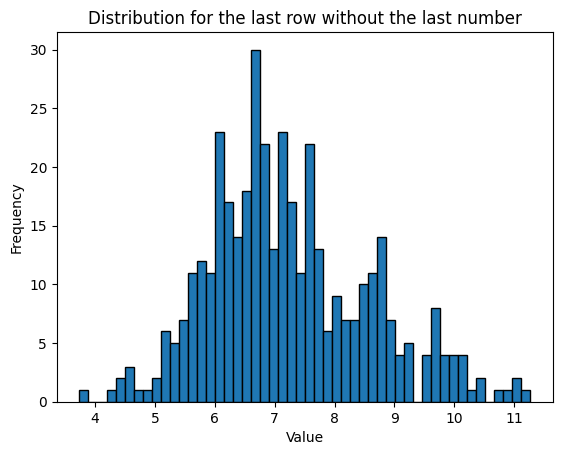

In [ ]:
last_row_without_last_number = pivot_sort.iloc[-1][:-1]
distributionB_large = last_row_without_last_number.apply(np.log)

# Plot the histogram for the last row without the last number
distributionB_large.T.plot(kind='hist', edgecolor='black', bins=50)

# Add labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution for the last row without the last number')

# Show the plot
plt.show()

In [ ]:
data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)

# Move the first column to the last position
first_column = df.pop(df.columns[0])
df[first_column.name] = first_column

print("\nModified DataFrame:")
print(df)

Original DataFrame:
   A  B  C
0  1  4  7
1  2  5  8
2  3  6  9

Modified DataFrame:
   B  C  A
0  4  7  1
1  5  8  2
2  6  9  3


## Production-constrained Model
parameter 1

In [ ]:
unique_categories_array = flow_calibrate['station_origin'].unique()
num_unique_categories = len(unique_categories_array)
num_unique_categories

398

In [ ]:
formula = 'flows_c ~ station_origin + log_jobs + log_distance-1' #adjust
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=flow_calibrate, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                flows_c   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sun, 07 May 2023   Deviance:                   1.8612e+06
Time:                        19:12:27   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
#aee alpha to dataframe
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

flow_calibrate = flow_calibrate.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flow_calibrate.drop(columns = ["coef"], inplace = True)
flow_calibrate.head(2)

<ipython-input-84-3b6c2415b988>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249


In [ ]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]
print(gamma)
print(beta)

0.7685989966422357
0.8780975513417709


In [ ]:
flow_calibrate["prodsimest_orig"] = np.exp(flow_calibrate["alpha_i"]+gamma*flow_calibrate["log_jobs"]
                                 - beta*flow_calibrate["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.011438
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.986205


In [ ]:
flow_calibrate["prodsimest_orig"] = round(flow_calibrate["prodsimest_orig"],2)
pivot_prodimest_orig = flow_calibrate.pivot_table(values ="prodsimest_orig", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
pivot_prodimest_orig

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,599.01
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.33,NaN,NaN,1224.02
Acton Town,NaN,NaN,NaN,18.15,18.19,NaN,8.74,0.66,NaN,19.95,...,16.50,2.97,5.15,12.61,NaN,1.66,NaN,2.05,NaN,3745.09
Aldgate,NaN,NaN,1.99,NaN,46.58,NaN,NaN,0.16,NaN,21.50,...,4.02,NaN,2.53,2.03,NaN,0.88,NaN,0.85,NaN,2886.16
Aldgate East,NaN,NaN,2.25,52.47,NaN,NaN,0.78,0.18,NaN,23.18,...,4.55,0.80,2.84,2.28,NaN,1.10,NaN,0.96,NaN,3172.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.25,35.09,38.72,NaN,NaN,NaN,NaN,32.29,...,15.34,NaN,9.63,NaN,NaN,NaN,NaN,NaN,NaN,4868.04
Woodgrange Park,NaN,4.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.02
Woodside Park,NaN,NaN,5.39,20.36,20.41,NaN,2.00,NaN,NaN,24.82,...,11.27,NaN,6.23,NaN,NaN,NaN,NaN,NaN,NaN,3093.10


In [ ]:
CalcRSquared(flow_calibrate["flows_c"], flow_calibrate["prodsimest_orig"])

0.3882699212551461

In [ ]:
CalcRMSE(flow_calibrate["flows_c"], flow_calibrate["prodsimest_orig"])

102.893

## Production-constrained Model
parameter 2

In [ ]:
# Run a production constrained SIM with a negative exponential cost function.
formula = 'flows_c ~ station_origin + log_jobs + distance-1' #注意这个log是调整过的
#run a production constrained sim
prodSim_exp = smf.glm(formula = formula, data=flow_calibrate, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                flows_c   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sun, 07 May 2023   Deviance:                   1.6474e+06
Time:                        19:13:15   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
formula = 'flows_c ~ station_origin + log_jobs + distance-1' #this log is adjuested
#run a production constrained sim
prodSim_exp_save = smf.glm(formula = formula, data=flow_calibrate, family=sm.families.Poisson()).fit()
#let's have a look at it's summary

summary_df = pd.read_html(prodSim_exp_save.summary().tables[1].as_html(), header=0, index_col=0)[0]

# Save the DataFrame to an Excel file
summary_df.to_excel('prodSim_summary_exp.xlsx')

In [ ]:
#add alpha to dataframe
coefs_exp = pd.DataFrame(prodSim_exp.params)
coefs_exp.reset_index(inplace=True)
coefs_exp.rename(columns = {0:"alpha_i_exp", "index":"coef_exp"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs_exp["coef_exp"] = coefs_exp["coef_exp"].str.replace(x, "")

flow_calibrate = flow_calibrate.merge(coefs_exp, left_on="station_origin", right_on="coef_exp", how = "left")
flow_calibrate.drop(columns = ["coef_exp"], inplace = True)
flow_calibrate.head(2)

<ipython-input-92-5448365b694e>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs_exp["coef_exp"] = coefs_exp["coef_exp"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156


In [ ]:
alpha_i_exp = prodSim_exp.params[0:398]
gamma_exp = prodSim_exp.params[398]
beta_exp = -prodSim_exp.params[399]
print(gamma_exp)
print(beta_exp)

0.7552024675540053
0.0001531586999873572


In [ ]:
flow_calibrate["prodsimest_exp"] = np.exp(flow_calibrate["alpha_i_exp"]+gamma_exp*flow_calibrate["log_jobs"]
                                 - beta_exp*flow_calibrate["distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp,prodsimest_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156,77.686224
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156,1.466116


In [ ]:
#latter
CalcRSquared(flow_calibrate["flows_c"], flow_calibrate["prodsimest_exp"])

0.46806325616484723

In [ ]:
CalcRMSE(flow_calibrate["flows_c"], flow_calibrate["prodsimest_exp"])

96.264

# 2. Scenario A

Assume that Canary Wharf has a 50% decrease in jobs after Brexit.

In [ ]:
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp,prodsimest_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156,77.686224
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156,1.466116


In [ ]:
def update_jobs(row):
    if row['station_destination'] == 'Canary Wharf':
        new_jobs = row['jobs'] * 0.5  # Decrease the jobs by 50%
    else:
        new_jobs = row['jobs']
    return new_jobs

# Apply the custom function and create a new column with updated jobs
flow_calibrate['decrease_jobs'] = flow_calibrate.apply(update_jobs, axis=1)
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp,prodsimest_exp,decrease_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156,77.686224,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156,1.466116,442.0


**calculating Ai**

In [ ]:
Dj2_gamma = flow_calibrate["jobs"]**gamma_exp
dist_beta = np.exp(flow_calibrate['distance']* (-beta_exp))
#calcualte the first stage of the Ai values
flow_calibrate["Ai1"] = Dj2_gamma * dist_beta
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156,77.686224,78549.0,1432.009698
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156,1.466116,442.0,27.025289


In [ ]:
A_i = pd.DataFrame(flow_calibrate.groupby(["station_origin"])["Ai1"].agg(np.sum)) #新建了一个数据集，存7个A_i
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
A_i

,A_i
station_origin,
Abbey Road,0.000091
Acton Central,0.000256
Acton Town,0.000053
Aldgate,0.000018
Aldgate East,0.000018
...,...
Wood Street,0.000285
Woodford,0.000109
Woodgrange Park,0.000770


In [ ]:
flow_calibrate = flow_calibrate.merge(A_i, left_on="station_origin", right_index=True, how="left")
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156,77.686224,78549.0,1432.009698,0.000091
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156,1.466116,442.0,27.025289,0.000091


In [ ]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flow_calibrate.groupby(["station_origin"])["flows_c"].agg(np.sum))
O_i.rename(columns={"flows_c":"O_i"}, inplace = True)
flow_calibrate = flow_calibrate.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flow_calibrate.groupby(["station_destination"])["flows_c"].agg(np.sum))
D_j.rename(columns={"flows_c":"D_j"}, inplace = True)
flow_calibrate = flow_calibrate.merge(D_j, on = "station_destination", how = "left" )
flow_calibrate.head(5)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,alpha_i,prodsimest_orig,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1,A_i,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,3.250249,55.01,-2.914156,77.686224,78549.0,1432.009698,0.000091,599.004,78549.006
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,3.250249,0.99,-2.914156,1.466116,442.0,27.025289,0.000091,599.004,442.011
2,Abbey Road,Blackwall,3,599,665,3775.448872,3.000,6.395262,6.499787,8.236275,3.250249,2.76,-2.914156,4.121661,665.0,75.975610,0.000091,599.004,665.005
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1.000,6.395262,10.981421,8.534348,3.250249,66.46,-2.914156,99.483920,29386.0,1833.812116,0.000091,599.004,58772.009
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37.000,6.395262,9.643939,7.709274,3.250249,49.06,-2.914156,56.125577,15428.0,1034.576865,0.000091,599.004,15428.037


In [ ]:
# Test!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
flow_calibrate["prodsimest_test"] = flow_calibrate["A_i"]*flow_calibrate["O_i"]*Dj2_gamma*dist_beta #这里的Dj2_gamma用的是原来的jobs
#round
flow_calibrate["prodsimest_test"] = round(flow_calibrate["prodsimest_test"],6)
#check
flow_calibrate[["prodsimest_exp", "prodsimest_test"]]

# Successful!!!!!!!!!!!!!!!!!

,prodsimest_exp,prodsimest_test
0,77.686224,77.686224
1,1.466116,1.466116
2,4.121661,4.121661
3,99.483920,99.483920
4,56.125577,56.125577
...,...,...
61408,98.840225,98.840225
61409,295.255599,295.255599
61410,35.955616,35.955616
61411,125.115066,125.115066


In [ ]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = flow_calibrate["decrease_jobs"]**gamma_exp
#calcualte the first stage of the Ai values
flow_calibrate["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_calibrate.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
flow_calibrate = flow_calibrate.merge(A_i, left_on="station_origin", right_index=True, how="left")
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,prodsimest_orig,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,55.01,-2.914156,77.686224,78549.0,1432.009698,0.000091,599.004,78549.006,77.686224,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,0.99,-2.914156,1.466116,442.0,27.025289,0.000091,599.004,442.011,1.466116,0.000097


In [ ]:
#to check everything works, recreate the original estimates
flow_calibrate["prodsimest_decrease_jobs"] = flow_calibrate["A_i2"]*flow_calibrate["O_i"]*Dj3_gamma*dist_beta
#round
flow_calibrate["prodsimest_decrease_jobs"] = round(flow_calibrate["prodsimest_decrease_jobs"],2)

In [ ]:
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,-2.914156,77.686224,78549.0,1432.009698,0.000091,599.004,78549.006,77.686224,0.000097,83.33
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,-2.914156,1.466116,442.0,27.025289,0.000091,599.004,442.011,1.466116,0.000097,1.57


In [ ]:
pivot_decrease = flow_calibrate.pivot_table(values ="prodsimest_decrease_jobs", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
pivot_decrease

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.02,599.02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.33,NaN,NaN,1224.05
Acton Town,NaN,NaN,NaN,12.96,12.67,NaN,13.73,0.04,NaN,16.01,...,13.39,2.91,1.93,19.69,NaN,0.23,NaN,0.54,NaN,3745.11
Aldgate,NaN,NaN,1.33,NaN,37.67,NaN,NaN,0.00,NaN,27.78,...,2.12,NaN,2.52,2.07,NaN,0.67,NaN,0.55,NaN,2886.10
Aldgate East,NaN,NaN,1.40,40.66,NaN,NaN,0.29,0.00,NaN,29.31,...,2.24,0.49,2.66,2.18,NaN,0.92,NaN,0.58,NaN,3172.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.45,41.88,52.94,NaN,NaN,NaN,NaN,30.86,...,2.31,NaN,5.84,NaN,NaN,NaN,NaN,NaN,NaN,4868.09
Woodgrange Park,NaN,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.99
Woodside Park,NaN,NaN,1.95,19.41,18.97,NaN,0.40,NaN,NaN,31.69,...,3.12,NaN,3.81,NaN,NaN,NaN,NaN,NaN,NaN,3093.01


In [ ]:
pivot_decrease_sort = pivot_decrease.T.sort_values(by='All', ascending=False).T

first_column = pivot_decrease_sort.pop(pivot_decrease_sort.columns[0])
pivot_decrease_sort[first_column.name] = first_column

# Saving to excel
pivot_decrease_sort.to_excel("pivot_decrease.xlsx", index=True)

pivot_decrease_sort

<ipython-input-108-1c8c2a8e0b1d>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_decrease_sort[first_column.name] = first_column


station_destination,Bank and Monument,Stratford,Liverpool Street,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,Canary Wharf,Victoria,London Bridge,Green Park,...,Beckton Park,Grange Hill,Ruislip Gardens,Theydon Bois,South Hampstead,Hatch End,West Ruislip,Cheshunt,Emerson Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,83.33,187.19,NaN,NaN,NaN,NaN,63.22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599.02
Acton Central,NaN,39.90,NaN,NaN,NaN,68.27,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.83,0.84,NaN,NaN,NaN,1224.05
Acton Town,92.58,22.58,67.34,101.16,55.82,30.60,20.83,99.83,50.40,80.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3745.11
Aldgate,212.78,66.95,196.43,72.85,73.14,40.10,46.17,53.86,89.64,47.54,...,NaN,NaN,0.04,NaN,NaN,NaN,0.03,NaN,NaN,2886.10
Aldgate East,224.55,91.36,207.24,76.88,77.16,42.30,63.01,56.84,94.60,50.17,...,NaN,0.08,NaN,0.05,NaN,NaN,0.04,NaN,NaN,3172.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,231.85,569.49,218.23,79.38,83.44,100.87,151.21,58.69,97.67,51.80,...,NaN,6.71,NaN,4.01,NaN,NaN,NaN,NaN,NaN,4868.09
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.99
Woodside Park,117.88,35.40,102.80,120.70,110.47,60.56,24.58,69.09,49.66,70.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.01


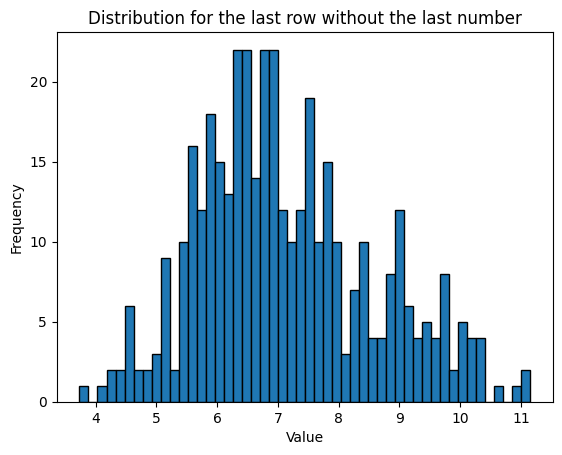

In [ ]:
last_row_without_last_number = pivot_decrease_sort.iloc[-1][:-1]
distributionA = last_row_without_last_number.apply(np.log)

# Plot the histogram for the last row without the last number
distributionA.T.plot(kind='hist', edgecolor='black', bins=50)

# Add labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution for the last row without the last number')

# Show the plot
plt.show()

# 3. Scenario B

Assume that Canary Wharf has a 50% decrease in jobs after Brexit.

In [ ]:
print(beta_exp)
beta_large = beta_exp*2
beta_larger = beta_exp*4
print(beta_large)
print(beta_larger)

print("beta_exp: {:.6f}".format(beta_exp))
print("beta_smaller: {:.6f}".format(beta_large))
print("beta_larger: {:.6f}".format(beta_larger))

0.0001531586999873572
0.0003063173999747144
0.0006126347999494288
beta_exp: 0.000153
beta_smaller: 0.000306
beta_larger: 0.000613


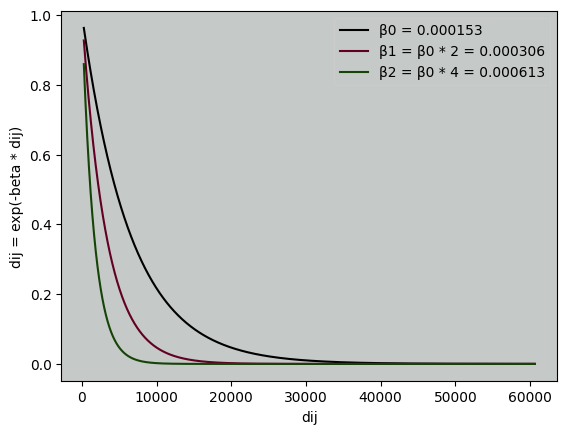

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dij_function(dij, beta):
    return np.exp(-beta * dij)

# Choose some values for dij
dij_values = flow_calibrate['distance']
dij_values = dij_values.sort_values()
# Choose some values for beta
#beta_values = [beta_smaller, beta_exp, beta_larger]
fig, ax = plt.subplots()
ax.set_facecolor('#c5c9c7')
#a03623
#colors = ['black', '#c292a1', '#154406']
colors = ['black', '#610023', '#154406']
beta_values = [('β0', beta_exp), ('β1 = β0 * 2', beta_large),('β2 = β0 * 4', beta_larger)]
# Create a plot for each value of beta
for (beta_name,beta),color in zip(beta_values, colors):
    plt.plot(dij_values, dij_function(dij_values, beta), label=f"{beta_name} = {beta:.6f}",color = color)

# Add labels and legend
plt.xlabel("dij")
plt.ylabel("dij = exp(-beta * dij)")
#plt.legend()
legend = ax.legend()
legend.get_frame().set_facecolor('#c5c9c7')
# Show the plot
plt.savefig('2beta.png', dpi=300, bbox_inches='tight')
plt.show()

**beta_large: recalculate Ai**

In [ ]:
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,-2.914156,77.686224,78549.0,1432.009698,0.000091,599.004,78549.006,77.686224,0.000097,83.33
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,-2.914156,1.466116,442.0,27.025289,0.000091,599.004,442.011,1.466116,0.000097,1.57


In [ ]:
Dj_gamma_large = flow_calibrate["jobs"]**gamma_exp #这里的jobs用的是原来的
dist_beta_large = np.exp(flow_calibrate['distance']* (-beta_large))
#calcualte the first stage of the Ai values
flow_calibrate["Ai1"] = Dj_gamma_large * dist_beta_large
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,alpha_i_exp,prodsimest_exp,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,-2.914156,77.686224,78549.0,412.163579,0.000091,599.004,78549.006,77.686224,0.000097,83.33
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,-2.914156,1.466116,442.0,7.340257,0.000091,599.004,442.011,1.466116,0.000097,1.57


In [ ]:
A_i = pd.DataFrame(flow_calibrate.groupby(["station_origin"])["Ai1"].agg(np.sum)) #新建了一个数据集，存7个A_i
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i_large"}, inplace=True)
A_i

,A_i_large
station_origin,
Abbey Road,0.000150
Acton Central,0.000713
Acton Town,0.000217
Aldgate,0.000034
Aldgate East,0.000034
...,...
Wood Street,0.001013
Woodford,0.000766
Woodgrange Park,0.001771


In [ ]:
flow_calibrate = flow_calibrate.merge(A_i, left_on="station_origin", right_index=True, how="left")
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,prodsimest_exp,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs,A_i_large
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,77.686224,78549.0,412.163579,0.000091,599.004,78549.006,77.686224,0.000097,83.33,0.00015
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,1.466116,442.0,7.340257,0.000091,599.004,442.011,1.466116,0.000097,1.57,0.00015


In [ ]:
flow_calibrate["prodsimest_B_large"] = flow_calibrate["A_i_large"]*flow_calibrate["O_i"]*Dj_gamma_large*dist_beta_large
#round
flow_calibrate["prodsimest_B_large"] = round(flow_calibrate["prodsimest_B_large"],6)
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs,A_i_large,prodsimest_B_large
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,78549.0,412.163579,0.000091,599.004,78549.006,77.686224,0.000097,83.33,0.00015,37.152690
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,442.0,7.340257,0.000091,599.004,442.011,1.466116,0.000097,1.57,0.00015,0.661656


In [ ]:
pivot_B_large = flow_calibrate.pivot_table(values ="prodsimest_B_large", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
pivot_B_large = pivot_B_large.T.sort_values(by='All', ascending=False).T

first_column = pivot_B_large.pop(pivot_B_large.columns[0])
pivot_B_large[first_column.name] = first_column

# Saving to excel
pivot_B_large.to_excel("pivot_B_large.xlsx", index=True)

pivot_B_large

<ipython-input-117-5ab98f1824ad>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_B_large[first_column.name] = first_column


station_destination,Bank and Monument,Stratford,Liverpool Street,Canary Wharf,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,Victoria,London Bridge,Green Park,...,Theobalds Grove,Beckton,Hatch End,Chesham,Cheshunt,Kilburn High Road,Emerson Park,South Hampstead,Beckton Park,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,37.152690,242.240581,NaN,75.847457,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.661656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.990040e+02
Acton Central,NaN,3.686665,NaN,NaN,NaN,NaN,19.605014,NaN,NaN,NaN,...,NaN,NaN,0.207118,NaN,NaN,7.224019,NaN,4.893784,NaN,1.224024e+03
Acton Town,35.032743,2.692585,22.400272,6.290392,64.385894,24.331040,8.982203,77.974616,21.521453,59.885908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.745052e+03
Aldgate,313.811265,40.137891,323.213939,52.409962,56.630261,70.838587,26.151228,38.485840,115.411703,35.335839,...,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,2.886114e+03
Aldgate East,323.235144,69.134443,332.743328,90.272147,58.330890,72.927137,26.922251,39.641585,118.877564,36.396988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.172088e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,137.098589,1068.662640,146.793097,206.816532,24.740759,33.923019,60.905234,16.813782,50.421331,15.437603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.868025e+03
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300130e+02
Woodside Park,68.580251,7.988143,63.026126,10.577103,110.668540,115.068691,42.479498,45.088997,25.222051,55.422079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.093029e+03


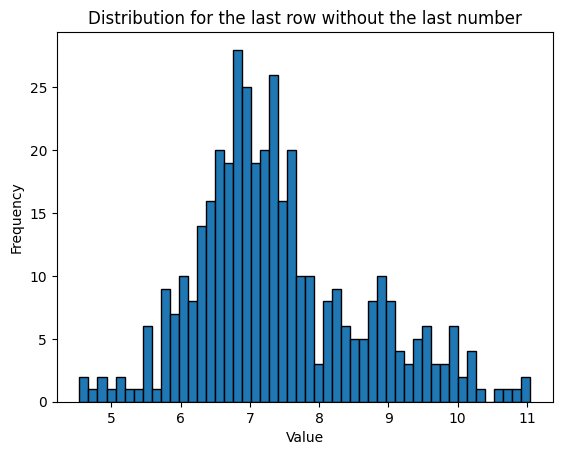

In [ ]:
last_row_without_last_number = pivot_B_large.iloc[-1][:-1]
distributionB_large = last_row_without_last_number.apply(np.log)

# Plot the histogram for the last row without the last number
distributionB_large.T.plot(kind='hist', edgecolor='black', bins=50)

# Add labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution for the last row without the last number')

plt.show()

**beta_larger: recalculate Ai**

In [ ]:
Dj_gamma_larger = flow_calibrate["jobs"]**gamma_exp
dist_beta_larger = np.exp(flow_calibrate['distance']* (-beta_larger))
#calcualte the first stage of the Ai values
flow_calibrate["Ai1"] = Dj2_gamma * dist_beta_larger
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,decrease_jobs,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs,A_i_large,prodsimest_B_large
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,78549.0,34.144198,0.000091,599.004,78549.006,77.686224,0.000097,83.33,0.00015,37.152690
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,442.0,0.541493,0.000091,599.004,442.011,1.466116,0.000097,1.57,0.00015,0.661656


In [ ]:
A_i = pd.DataFrame(flow_calibrate.groupby(["station_origin"])["Ai1"].agg(np.sum)) #store 7个A_i
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i_larger"}, inplace=True)
A_i

,A_i_larger
station_origin,
Abbey Road,0.000294
Acton Central,0.002264
Acton Town,0.001037
Aldgate,0.000078
Aldgate East,0.000082
...,...
Wood Street,0.002976
Woodford,0.005741
Woodgrange Park,0.004714


In [ ]:
flow_calibrate = flow_calibrate.merge(A_i, left_on="station_origin", right_index=True, how="left")
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,Ai1,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs,A_i_large,prodsimest_B_large,A_i_larger
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,34.144198,0.000091,599.004,78549.006,77.686224,0.000097,83.33,0.00015,37.152690,0.000294
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,0.541493,0.000091,599.004,442.011,1.466116,0.000097,1.57,0.00015,0.661656,0.000294


In [ ]:
flow_calibrate["prodsimest_B_larger"] = flow_calibrate["A_i_larger"]*flow_calibrate["O_i"]*Dj_gamma_large*dist_beta_larger
#round
flow_calibrate["prodsimest_B_larger"] = round(flow_calibrate["prodsimest_B_larger"],6)
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs,A_i_large,prodsimest_B_large,A_i_larger,prodsimest_B_larger
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,0.000091,599.004,78549.006,77.686224,0.000097,83.33,0.00015,37.152690,0.000294,6.022580
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,0.000091,599.004,442.011,1.466116,0.000097,1.57,0.00015,0.661656,0.000294,0.095512


In [ ]:
pivot_B_larger = flow_calibrate.pivot_table(values ="prodsimest_B_larger", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
pivot_B_larger = pivot_B_larger.T.sort_values(by='All', ascending=False).T

first_column = pivot_B_larger.pop(pivot_B_larger.columns[0])
pivot_B_larger[first_column.name] = first_column

# Saving to excel
pivot_B_larger.to_excel("pivot_B_larger.xlsx", index=True)

pivot_B_larger

<ipython-input-123-997836178a1a>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_B_larger[first_column.name] = first_column


station_destination,Bank and Monument,Stratford,Canary Wharf,Liverpool Street,Oxford Circus,King's Cross St. Pancras,Highbury & Islington,London Bridge,Green Park,Moorgate,...,Hatch End,Crouch Hill,Kilburn High Road,Cheshunt,Emerson Park,Beckton,South Hampstead,Beckton Park,Chesham,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,6.022580,330.783878,31.247629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.095512,NaN,NaN,NaN,5.990040e+02
Acton Central,NaN,0.012833,NaN,NaN,NaN,NaN,0.659200,NaN,NaN,NaN,...,0.005087,0.070382,2.798411,NaN,NaN,NaN,1.405695,NaN,NaN,1.224024e+03
Acton Town,1.445902,0.011035,0.058034,0.714449,7.518234,1.332533,0.223065,1.130809,9.529878,0.373533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.745052e+03
Aldgate,464.376181,9.815004,16.124772,595.370266,23.279502,45.210423,7.568186,130.163149,13.280398,229.320104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2.886114e+03
Aldgate East,464.988304,27.481620,45.148718,595.521843,23.310188,45.221933,7.570113,130.334725,13.297904,229.378487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.172088e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,7.595429,596.233118,21.517402,10.523778,0.380764,0.888467,3.517793,2.128974,0.217217,4.053467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.868025e+03
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.066565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.300130e+02
Woodside Park,2.551976,0.044732,0.075569,2.604916,10.229879,13.726465,2.297799,0.715311,3.759166,1.707807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.093029e+03


In [ ]:
flow_calibrate.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_c,log_population,log_jobs,log_distance,...,A_i,O_i,D_j,prodsimest_test,A_i2,prodsimest_decrease_jobs,A_i_large,prodsimest_B_large,A_i_larger,prodsimest_B_larger
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.001,6.395262,11.271478,9.003504,...,0.000091,599.004,78549.006,77.686224,0.000097,83.33,0.00015,37.152690,0.000294,6.022580
1,Abbey Road,Beckton,1,599,442,8510.121774,1.000,6.395262,6.091310,9.049012,...,0.000091,599.004,442.011,1.466116,0.000097,1.57,0.00015,0.661656,0.000294,0.095512


In [ ]:
import pandas as pd

# Assuming you have these four dataframes: pivot_B_larger, pivot_B_large, pivot_decrease_sort, pivot

# Extract the last row of each dataframe
last_row_B_larger = pivot_B_larger.iloc[-1]
last_row_B_large = pivot_B_large.iloc[-1]
last_row_decrease_sort = pivot_decrease_sort.iloc[-1]
last_row_pivot = pivot.iloc[-1]

# Combine the last rows into a new dataframe, with each row as a column
new_df = pd.concat([last_row_B_larger, last_row_B_large, last_row_decrease_sort, last_row_pivot], axis=1)

# Optional: Set the column names for the new dataframe
new_df.columns = ['B_larger', 'B_large', 'decrease_sort', 'pivot']
new_df

,B_larger,B_large,decrease_sort,pivot
station_destination,,,,
Bank and Monument,5.120421e+04,6.298796e+04,70019.15,78549.006
Stratford,4.978816e+04,6.098033e+04,67142.79,55954.034
Canary Wharf,4.066977e+04,4.526001e+04,29493.89,58772.009
Liverpool Street,3.531105e+04,4.948401e+04,59367.45,61122.008
Oxford Circus,2.950608e+04,3.838600e+04,40065.21,44368.003
...,...,...,...,...
Beckton,1.543022e+02,1.750927e+02,262.56,442.011
South Hampstead,1.402550e+02,9.548955e+01,84.40,236.007
Beckton Park,1.200423e+02,9.372034e+01,93.01,88.011


In [ ]:
new_df_int = new_df.astype(int)
new_df_int

,B_larger,B_large,decrease_sort,pivot
station_destination,,,,
Bank and Monument,51204,62987,70019,78549
Stratford,49788,60980,67142,55954
Canary Wharf,40669,45260,29493,58772
Liverpool Street,35311,49484,59367,61122
Oxford Circus,29506,38386,40065,44368
...,...,...,...,...
Beckton,154,175,262,442
South Hampstead,140,95,84,236
Beckton Park,120,93,93,88


In [ ]:
new_df_int = new_df_int.rename(columns={'B_larger': 'ScenarioB-beta2', 'B_large': 'ScenarioB-beta1','decrease_sort':'ScenarioA','pivot':'Origin'})

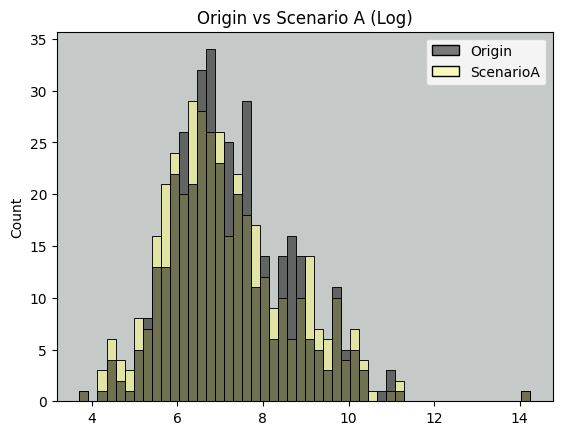

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

log_new_df_int = new_df_int[['Origin','ScenarioA']].applymap(lambda x: np.log(x) if x > 0 else 0)
fig, ax = plt.subplots()
ax.set_facecolor('#c5c9c7')
#color_palette = ['black', '#ffff81']
color_palette = ['black', '#ffff81']
sns.histplot(data=log_new_df_int,bins=50,palette=color_palette);
#sns.histplot(data=log_new_df_int,bins=50);
ax.set_title("Origin vs Scenario A (Log)")
plt.savefig('A.png', dpi=300, bbox_inches='tight')
plt.show()

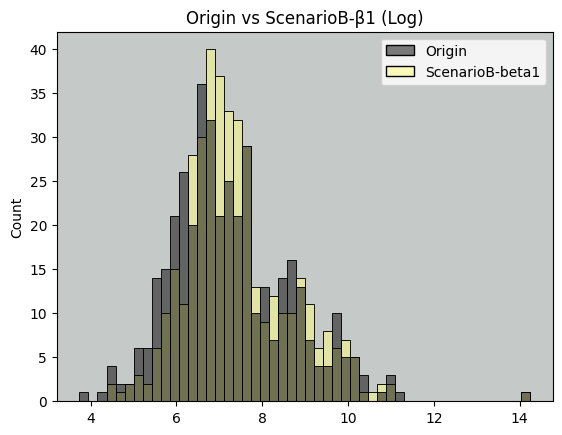

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

log_new_df_int = new_df_int[['Origin','ScenarioB-beta1']].applymap(lambda x: np.log(x) if x > 0 else 0)
fig, ax = plt.subplots()
ax.set_facecolor('#c5c9c7')
#color_palette = ['black', '#ffff81']
color_palette = ['black', '#ffff81']
sns.histplot(data=log_new_df_int,bins=50,palette=color_palette);
#sns.histplot(data=log_new_df_int,bins=50);
ax.set_title("Origin vs ScenarioB-β1 (Log)")
plt.savefig('B1.png', dpi=300, bbox_inches='tight')
plt.show();

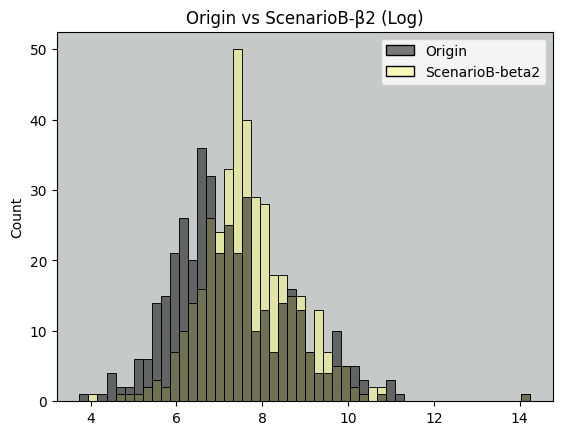

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

log_new_df_int = new_df_int[['Origin','ScenarioB-beta2']].applymap(lambda x: np.log(x) if x > 0 else 0)
fig, ax = plt.subplots()
ax.set_facecolor('#c5c9c7')
#ax.set_facecolor('#95a3a6')
#color_palette = ['black', '#ffff81']
color_palette = ['black', '#ffff81']
sns.histplot(data=log_new_df_int,bins=50,palette=color_palette);
#sns.histplot(data=log_new_df_int,bins=50);
ax.set_title("Origin vs ScenarioB-β2 (Log)")
plt.savefig('B2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
TOP = pd.read_csv("/content/drive/MyDrive/US_Wendi_Li/TOP10.csv")
TOP
LAST = pd.read_csv("/content/drive/MyDrive/US_Wendi_Li/LAST3.csv")
LAST

,Original,ScenarioB1,ScenarioB2
0,84.04,113.01,140.26
1,76.08,95.49,120.04
2,42.00,93.72,58.96


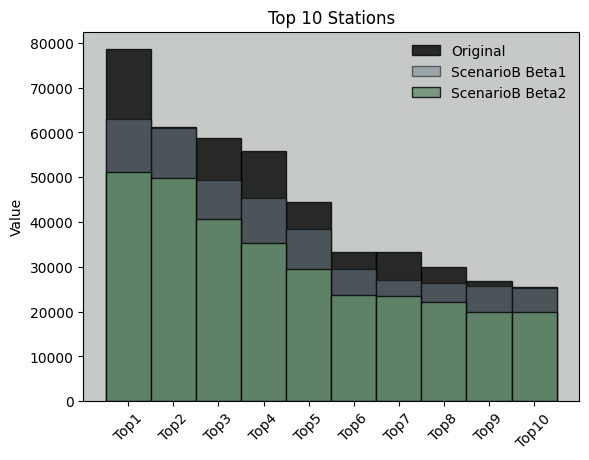

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x = np.arange(1, 11)


# Create a figure and axes
fig, ax = plt.subplots()
ax.set_facecolor('#c5c9c7')
# Plot the first bar chart
ax.bar(x,TOP['Original'], alpha=0.8, label='Original', color='black', edgecolor='black',width=1)

# Plot the second bar chart on top of the first
ax.bar(x, TOP['ScenarioB1'], alpha=0.5, label='ScenarioB Beta1', color='#6f828a', edgecolor='black',width=1)
#ffff81
#6f828a
# Plot the third bar chart on top of the first and second
ax.bar(x, TOP['ScenarioB2'], alpha=0.8, label='ScenarioB Beta2', color='#658d6d', edgecolor='black',width=1)

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels([f"Top{i}" for i in x])

# Set y-axis label
ax.set_ylabel("Value")

# Set the title
ax.set_title("Top 10 Stations")
plt.xticks(rotation=45)
# Add the legend
legend = ax.legend()
legend.get_frame().set_facecolor('#c5c9c7')
# Show the plot
plt.savefig('Top10.png', dpi=300, bbox_inches='tight')
plt.show()